In [ ]:
%cd /content/drive/MyDrive/Master_assignment/Seminar2/code-comment-classification

/content/drive/MyDrive/Master_assignment/Seminar2/code-comment-classification


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Master_assignment/Seminar2/code-comment-classification/python/input/python.csv")

In [ ]:
import matplotlib.pyplot as plt

df['unique_word_count'] = df['comment_sentence'].apply(lambda x: len(set(str(x).split())))

print(df[['comment_sentence', 'unique_word_count']])


                                        comment_sentence  unique_word_count
0      abstract cbv mixin that gives access mixins th...                 10
1                                         functionality.                  1
2         more than one migration matches a name prefix.                  8
3                                  stub of an appconfig.                  4
4            only provides a label and a dict of models.                  8
...                                                  ...                ...
12770              server s response to an http request.                  7
12771  base class that all auth implementations deriv...                  8
12772     the header value provided was somehow invalid.                  7
12773  the fully mutable class preparedrequest prepar...                  6
12774  containing the exact bytes that will be sent t...                 10

[12775 rows x 2 columns]


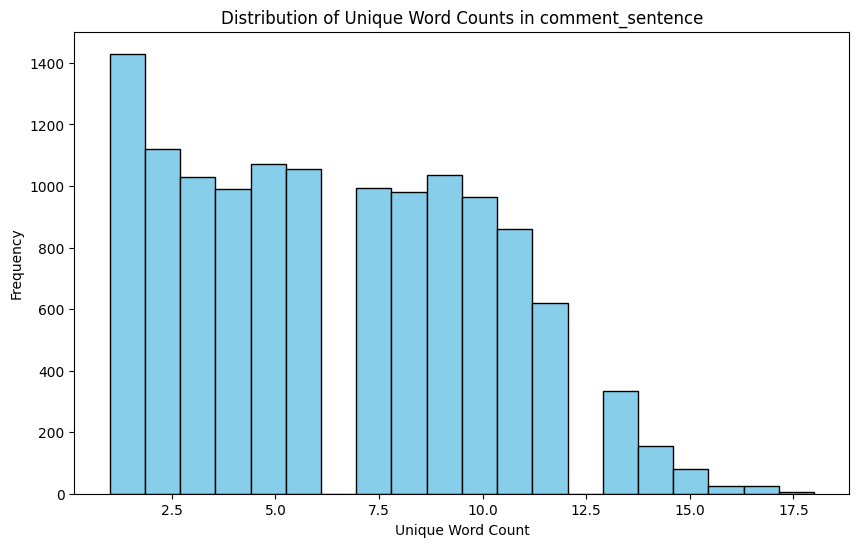

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df['unique_word_count'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Unique Word Counts in comment_sentence')
plt.xlabel('Unique Word Count')
plt.ylabel('Frequency')
plt.show()

In [ ]:
df

,comment_sentence_id,class,comment_sentence,partition,instance_type,category
0,2,Abfss.java,this impl delegates to the old filesystem,0,0,summary
1,516,FileSystemApplicationHistoryStore.java,@link #applicationstarted applicationstartdata...,1,0,summary
2,517,FileSystemApplicationHistoryStore.java,be invoked first when writing any history data...,0,0,summary
3,6,AbstractContractGetFileStatusTest.java,the tree parameters.,1,0,summary
4,518,FileSystemApplicationHistoryStore.java,"open a file, while @link #applicationfinished ...",0,0,summary
...,...,...,...,...,...,...
16921,5108,VScrollTable.java,example itabpanel just set contained component...,0,1,rational
16922,5109,VScrollTable.java,when changing tabs.,0,1,rational
16923,5110,VScrollTable.java,updates first visible row for the case we cann...,0,1,rational
16924,5111,VScrollTable.java,this method has logic which rows needs to be r...,0,1,rational


# **RoBERTa**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 46.6 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np

def transform_to_multi_label(df):
    dummies = pd.get_dummies(df['category'])

    dummies = dummies.multiply(df['instance_type'], axis=0)

    result_df = pd.concat([df[['comment_sentence']], dummies], axis=1)

    result_df = result_df.groupby('comment_sentence').max().reset_index()

    return result_df

In [4]:
from torch.utils.data import Dataset
class CodeCommentDataset(Dataset):

  def __init__(self, data, tokenizer, attributes, max_token_len: int = 128, sample = 5000):
    self.data = data
    self.tokenizer = tokenizer
    self.attributes = attributes
    self.max_token_len = max_token_len
    self.sample = sample
    self._prepare_data()


  def _prepare_data(self):
      self.data = self.data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
      item = self.data.iloc[index]
      comment = str(item['comment_sentence'])

      attributes = item[self.attributes].astype(float).values
      attributes = torch.FloatTensor(attributes)

      tokens = self.tokenizer.encode_plus(comment,
                                          add_special_tokens=True,
                                          return_tensors='pt',
                                          truncation=True,
                                          padding='max_length',
                                          max_length=self.max_token_len,
                                          return_attention_mask=True)

      return {
          'input_ids': tokens.input_ids.flatten(),
          'attention_mask': tokens.attention_mask.flatten(),
          'labels': attributes
      }


In [5]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader
class Data_Module(pl.LightningDataModule):

  def __init__(self, train_data, val_data, test_data, attributes, batch_size: int = 16, max_token_length: int = 128, model_name='roberta-base'):
    super().__init__()
    self.train_data = train_data
    self.val_data = val_data
    self.test_data = test_data
    self.attributes = attributes
    self.batch_size = batch_size
    self.max_token_length = max_token_length
    self.model_name = model_name
    self.tokenizer = AutoTokenizer.from_pretrained(model_name)

  def setup(self, stage=None):
    if stage in (None, "fit"):
      self.train_dataset = CodeCommentDataset(self.train_data, attributes=self.attributes, tokenizer=self.tokenizer)
      self.val_dataset = CodeCommentDataset(self.val_data, attributes=self.attributes, tokenizer=self.tokenizer, sample=None)
    if stage == 'predict':
      self.test_dataset = CodeCommentDataset(self.test_data, attributes=self.attributes, tokenizer=self.tokenizer, sample=None)

  def train_dataloader(self):
    return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=2, shuffle=True)

  def val_dataloader(self):
    return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=2, shuffle=False)

  def predict_dataloader(self):
    return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=2, shuffle=False)



In [6]:
from transformers import AutoModel, AdamW, get_cosine_schedule_with_warmup
import torch.nn as nn
import math
from torchmetrics.functional.classification import auroc
import torch.nn.functional as F
class Comment_Classifier(pl.LightningModule):

  def __init__(self, config: dict):
    super().__init__()
    self.config = config
    self.pretrained_model = AutoModel.from_pretrained(config['model_name'], return_dict = True)
    self.hidden = torch.nn.Linear(self.pretrained_model.config.hidden_size, self.pretrained_model.config.hidden_size)
    self.classifier = torch.nn.Linear(self.pretrained_model.config.hidden_size, self.config['n_labels'])
    torch.nn.init.xavier_uniform_(self.classifier.weight)
    self.loss_func = nn.BCEWithLogitsLoss(reduction='mean')
    self.dropout = nn.Dropout()

  def forward(self, input_ids, attention_mask, labels=None):
    # roberta layer
    output = self.pretrained_model(input_ids=input_ids, attention_mask=attention_mask)
    pooled_output = torch.mean(output.last_hidden_state, 1)
    # final logits
    pooled_output = self.dropout(pooled_output)
    pooled_output = self.hidden(pooled_output)
    pooled_output = F.relu(pooled_output)
    pooled_output = self.dropout(pooled_output)
    logits = self.classifier(pooled_output)
    # calculate loss
    loss = 0
    if labels is not None:
      loss = self.loss_func(logits.view(-1, self.config['n_labels']), labels.view(-1, self.config['n_labels']))
    return loss, logits

  def training_step(self, batch, batch_index):
    loss, outputs = self(**batch)
    self.log("train loss ", loss, prog_bar = True, logger=True)
    return {"loss":loss, "predictions":outputs, "labels": batch["labels"]}

  def validation_step(self, batch, batch_index):
    loss, outputs = self(**batch)
    self.log("validation loss ", loss, prog_bar = True, logger=True)
    return {"val_loss": loss, "predictions":outputs, "labels": batch["labels"]}

  def predict_step(self, batch, batch_index):
    loss, outputs = self(**batch)
    return outputs

  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=self.config['lr'], weight_decay=self.config['weight_decay'])
    total_steps = self.config['train_size']/self.config['batch_size']
    warmup_steps = math.floor(total_steps * self.config['warmup'])
    warmup_steps = math.floor(total_steps * self.config['warmup'])
    scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
    return [optimizer],[scheduler]

In [8]:
def classify_raw_comments(model, dm):
  predictions = trainer.predict(model, datamodule=dm)
  flattened_predictions = np.stack([torch.sigmoid(torch.Tensor(p)) for batch in predictions for p in batch])
  return flattened_predictions

In [9]:
from sklearn import metrics
import numpy as np

def calculate_metrics(true_labels, predictions, attributes):
    results = {}

    for i, attribute in enumerate(attributes):
        true = true_labels[:, i]
        pred = predictions[:, i]

        acc = metrics.accuracy_score(true, np.round(pred))
        pre = metrics.precision_score(true, np.round(pred), zero_division=0)
        rec = metrics.recall_score(true, np.round(pred), zero_division=0)
        f1 = metrics.f1_score(true, np.round(pred), zero_division=0)

        # weighted
        pre_weighted = metrics.precision_score(true, np.round(pred), average='weighted', zero_division=0)
        rec_weighted = metrics.recall_score(true, np.round(pred), average='weighted', zero_division=0)
        f1_weighted = metrics.f1_score(true, np.round(pred), average='weighted', zero_division=0)

        # AUC-ROC
        try:
            auc = metrics.roc_auc_score(true, pred)
        except ValueError:
            auc = None  # Nếu không tính được (ví dụ: chỉ có nhãn 1 hoặc nhãn 0)

        results[attribute] = {
            'Accuracy': acc,
            'Precision': pre,
            'Recall': rec,
            'F1-Score': f1,
            'Precision (weighted)': pre_weighted,
            'Recall (weighted)': rec_weighted,
            'F1-Score (weighted)': f1_weighted,
            'AUC-ROC': auc
        }

    return results

In [11]:
import torch
from transformers import AutoTokenizer
import numpy as np
import pandas as pd

metrics_df = pd.DataFrame()
metrics_list = []

# Loop through each language and each category
for language in ["java", "python", "pharo"]:
    # Load the dataset for the current language
    df = pd.read_csv(f"/content/drive/MyDrive/Master_assignment/Seminar2/code-comment-classification/{language}/input/{language}.csv")
    df = transform_to_multi_label(df)
    train_data, temp_data = np.split(df.sample(frac=1, random_state=42), [int(0.7 * len(df))])
    valid_data, test_data = np.split(temp_data.sample(frac=1, random_state=42), [int(0.5 * len(temp_data))])
    train_data_reset = train_data.reset_index(drop=True)
    valid_data_reset = valid_data.reset_index(drop=True)
    test_data_reset = test_data.reset_index(drop=True)

    # Attributes
    attributes = [label for label in df.columns if label != 'comment_sentence']
    model_name = 'roberta-base'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    ds = CodeCommentDataset(train_data, tokenizer, attributes=attributes)
    ds_val = CodeCommentDataset(valid_data, tokenizer, attributes=attributes, sample=None)
    ds_test = CodeCommentDataset(test_data, tokenizer, attributes=attributes, sample=None)
    # Model
    config = {
    'model_name': 'distilroberta-base',
    'n_labels': len(attributes),
    'batch_size': 32,
    'lr': 1e-5,
    'warmup': 0.2,
    'train_size': len(train_data),
    'weight_decay': 0.001,
    'n_epochs': 50
    }

    data_module = Data_Module(train_data, valid_data, test_data, attributes=attributes, batch_size=config['batch_size'])
    data_module.setup()

    model = Comment_Classifier(config)

    # Train
    trainer = pl.Trainer(max_epochs=config['n_epochs'], devices=1, num_sanity_val_steps=5, log_every_n_steps=1)
    trainer.fit(model, data_module)

    # Predict
    predictions = classify_raw_comments(model, data_module)
    true_labels = np.array(test_data[attributes])

    # Calculate metrics
    metrics_results = calculate_metrics(true_labels, predictions, attributes)

    # Convert metrics to DataFrame format
    for attribute, metric_values in metrics_results.items():
        row = {
            'category': f"{language}_{attribute}",
            'Accuracy': metric_values['Accuracy'],
            'Precision': metric_values['Precision'],
            'Recall': metric_values['Recall'],
            'F1-Score': metric_values['F1-Score'],
            'Precision (weighted)': metric_values['Precision (weighted)'],
            'Recall (weighted)': metric_values['Recall (weighted)'],
            'F1-Score (weighted)': metric_values['F1-Score (weighted)'],
            'AUC-ROC': metric_values['AUC-ROC']
        }
        metrics_list.append(row)
metrics_df = pd.DataFrame(metrics_list)
# Save to CSV
metrics_df.to_csv("/content/drive/MyDrive/Master_assignment/Seminar2/code-comment-classification/results/RoBERTa_Results_test.csv", index=False)




/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/transform

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/transform

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/transform

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]